In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import img_to_array

warnings.filterwarnings('ignore')

2023-08-26 16:14:11.049649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 16:14:11.930784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-26 16:14:17.529761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-26 16:14:17.631994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-26 16:14:17.632191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Create 2 virtual GPUs with 1GB memory each
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
#          tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

os - used to handle files using system commands

numpy - used to perform a wide variety of mathematical operations on arrays

matplotlib - used for data visualization and graphical plotting

warnings - used to control and suppress warning messages that may be generated by the Python interpreter or third-party libraries during the execution of a Python program

tqdm.notebook - used for adding progress bars to your code in Jupyter Notebook

tensorflow - used for various tasks in machine learning and deep learning

tensorflow.keras.preprocessing.image - provides a variety of image preprocessing utilities for working with images in TensorFlow

tensorflow.keras.models - provides various classes and functions for creating and working with neural network models using the Keras API within TensorFlow

tensorflow.keras - provides an interface to build, train, and deploy deep learning models using the Keras API within TensorFlow

tensorflow.keras.optimizers - provides a collection of optimization algorithms that can be used to train deep learning models in TensorFlow using the Keras API

tensorflow.keras.losses - provides a collection of loss functions that can be used to measure the discrepancy between the predicted and target values during the training of deep learning models using the Keras API within TensorFlow



### Load the Dataset

In [3]:
BASE_DIR='/home/lagrangian/DEEP/animeface-character-dataset/data'

### we will create a list which will contain all the dataset images



In [4]:
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

os.listdir() function retrieves a list of all files and directories present in the BASE_DIR directory

os.path.join() creates the complete path of the image file by joining the base directory path with the image name

The resulting image path is then appended to the image_paths list

In [6]:
image_paths[:2]

['/home/lagrangian/DEEP/animeface-character-dataset/data/2705.png',
 '/home/lagrangian/DEEP/animeface-character-dataset/data/13543.png']

In [7]:
len(image_paths)

21551

### Visualize the Image Dataset

In [4]:
# to display grid of images (7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    img = load_img(image_path)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    index += 1

NameError: name 'image_paths' is not defined

<Figure size 2000x2000 with 0 Axes>

In [5]:
batch_size = 32
SIZE=64
ip_channel=3
LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
def load_face_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = load_img(image_path, color_mode='rgb', target_size=(SIZE,SIZE))
        image = img_to_array(image) / 255.0-0.005
        images.append(image)
    return np.array(images)

folder_path = '/home/lagrangian/DEEP/animeface-character-dataset/data'
training_images = load_face_images(folder_path)

In [9]:
# load the image and convert to numpy array
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [10]:
train_images[0].shape

(64, 64, 3)

In [11]:
# reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [12]:
# normalize the images
train_images = (train_images - 127.5) / 127.5

In [14]:
train_images[0]

array([[[ 0.52156866, -0.16078432,  0.10588235],
        [ 0.8901961 ,  0.33333334,  0.5294118 ],
        [-0.02745098, -0.5921569 , -0.30980393],
        ...,
        [ 0.90588236,  0.9529412 ,  0.9372549 ],
        [ 1.        ,  0.9843137 ,  1.        ],
        [ 0.9529412 ,  0.92156863,  0.9529412 ]],

       [[ 0.654902  , -0.00392157,  0.27058825],
        [ 0.35686275, -0.11372549,  0.13725491],
        [-0.42745098, -1.        , -0.7176471 ],
        ...,
        [ 0.9607843 ,  0.9764706 ,  0.9764706 ],
        [ 0.9764706 ,  0.9764706 ,  0.99215686],
        [ 0.92941177,  0.96862745,  0.96862745]],

       [[ 0.7882353 ,  0.13725491,  0.4117647 ],
        [-0.39607844, -0.8509804 , -0.5686275 ],
        [-0.07450981, -0.75686276, -0.4117647 ],
        ...,
        [ 1.        ,  1.        ,  1.        ],
        [ 0.92156863,  0.96862745,  0.96862745],
        [ 0.94509804,  1.        ,  1.        ]],

       ...,

       [[ 0.78039217,  0.20784314,  0.09803922],
        [ 0

In [13]:

LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 3 

In [14]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

2023-08-27 17:10:51.472429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 17:10:51.472783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 17:10:51.472965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

In [15]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [16]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [17]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [18]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [19]:
D_LR = 0.0001 
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [20]:
N_EPOCHS = 100
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

2023-08-27 17:11:21.892249: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1059274752 exceeds 10% of free system memory.
2023-08-27 17:11:22.965710: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1059274752 exceeds 10% of free system memory.


Epoch 1/100


2023-08-27 17:11:26.688955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-27 17:11:26.727050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-27 17:11:28.184534: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:11:28.405044: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:11:28.698136: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0

673/674 [============================>.] - ETA: 0s - d_loss: 0.6043 - g_loss: 2.7528

2023-08-27 17:12:17.291572: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:12:17.291642: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:12:17.468336: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:12:17.680027: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

674/674 [==============================] - ETA: 0s - d_loss: 0.6036 - g_loss: 2.7543

2023-08-27 17:12:19.859149: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:12:19.859208: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 17:12:20.014639: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


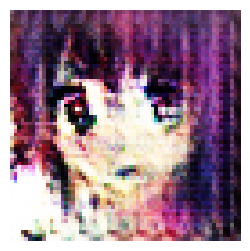

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()